In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
YEAR = 2023
data = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_' + str(YEAR) + '.csv.gz', compression='gzip', low_memory=False)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 400)


In [3]:
# Filter by team (Philadelphia Eagles)
filtered_df = data[(data['home_team'] == 'PHI') | (data['away_team'] == 'PHI')]
filtered_hurts = filtered_df[filtered_df['passer_player_name'] == 'J.Hurts']

In [4]:
# Group by game and sum up passing yards
passing_yards_per_game = filtered_hurts.groupby('game_id')['passing_yards'].sum()


In [5]:
# Calculate completion percentage per game
completions = filtered_hurts[filtered_hurts['pass_complete'] == 1].groupby('game_id').size()
attempts = filtered_hurts.groupby('game_id').size()
completion_percentage = completions / attempts


KeyError: 'pass_complete'

In [11]:
import pandas as pd

# Adjust display settings to show all columns
pd.set_option('display.max_columns', None)

# Assuming filtered_hurts is already defined and contains your DataFrame
print(filtered_hurts.head())


      play_id         game_id  old_game_id home_team away_team season_type  \
2104       55  2023_01_PHI_NE   2023091011        NE       PHI         REG   
2107      140  2023_01_PHI_NE   2023091011        NE       PHI         REG   
2110      209  2023_01_PHI_NE   2023091011        NE       PHI         REG   
2113      296  2023_01_PHI_NE   2023091011        NE       PHI         REG   
2118      418  2023_01_PHI_NE   2023091011        NE       PHI         REG   

      week posteam posteam_type defteam side_of_field  yardline_100  \
2104     1     PHI         away      NE           PHI          75.0   
2107     1     PHI         away      NE            NE          48.0   
2110     1     PHI         away      NE            NE          34.0   
2113     1     PHI         away      NE            NE          23.0   
2118     1     PHI         away      NE            NE           6.0   

       game_date  quarter_seconds_remaining  half_seconds_remaining  \
2104  2023-09-10                 

In [12]:
# Calculate completion percentage per game
completions = filtered_hurts[filtered_hurts['complete_pass'] == 1].groupby('game_id').size()
attempts = filtered_hurts[filtered_hurts['pass_attempt'] == 1].groupby('game_id').size()
completion_percentage = completions / attempts

print(completion_percentage)


game_id
2023_01_PHI_NE     0.611111
2023_02_MIN_PHI    0.666667
2023_03_PHI_TB     0.605263
2023_04_WAS_PHI    0.625000
2023_05_PHI_LA     0.641026
2023_06_PHI_NYJ    0.595745
2023_07_MIA_PHI    0.676471
2023_08_PHI_WAS    0.725000
2023_09_DAL_PHI    0.653846
2023_11_PHI_KC     0.518519
2023_12_BUF_PHI    0.545455
2023_13_SF_PHI     0.530612
2023_14_PHI_DAL    0.642857
2023_15_PHI_SEA    0.548387
2023_16_NYG_PHI    0.615385
2023_17_ARI_PHI    0.782609
2023_18_PHI_NYG    0.388889
2023_19_PHI_TB     0.657895
dtype: float64


C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_13264\2092643149.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['cumulative_completions'] = game_data['complete_pass'].cumsum()
C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_13264\2092643149.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['cumulative_attempts'] = game_data['pass_attempt'].cumsum()
C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_13264\2092643149.py:9: SettingWithCopyWarning: 
A value is trying

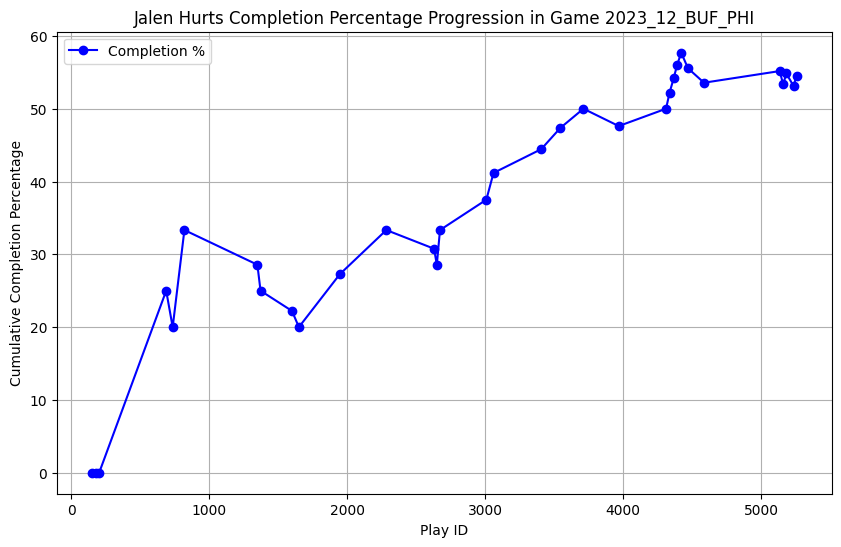

In [13]:
import matplotlib.pyplot as plt

# Filter the data for the specific game
game_data = filtered_hurts[filtered_hurts['game_id'] == '2023_12_BUF_PHI']

# Calculate cumulative completions and attempts
game_data['cumulative_completions'] = game_data['complete_pass'].cumsum()
game_data['cumulative_attempts'] = game_data['pass_attempt'].cumsum()
game_data['cumulative_completion_percentage'] = (game_data['cumulative_completions'] / game_data['cumulative_attempts']) * 100

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(game_data['play_id'], game_data['cumulative_completion_percentage'], marker='o', linestyle='-', color='blue', label='Completion %')
plt.xlabel('Play ID')
plt.ylabel('Cumulative Completion Percentage')
plt.title('Jalen Hurts Completion Percentage Progression in Game 2023_12_BUF_PHI')
plt.legend()
plt.grid()
plt.show()


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the theme for seaborn plots
sns.set_theme(style='whitegrid', palette='deep', font='DejaVu Sans', font_scale=1.5, color_codes=True)

# Import matplotlib
import matplotlib as mpl

# Set the resolution of the figures to 300 DPI
mpl.rcParams['figure.dpi'] = 300


In [15]:
# Filter the data for the specific game
game_data = filtered_hurts[filtered_hurts['game_id'] == '2023_12_BUF_PHI']

# Calculate additional metrics if needed
game_data['completion'] = game_data['complete_pass'].cumsum()
game_data['attempt'] = game_data['pass_attempt'].cumsum()
game_data['completion_percentage'] = (game_data['completion'] / game_data['attempt']) * 100


C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_13264\362664746.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['completion'] = game_data['complete_pass'].cumsum()
C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_13264\362664746.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['attempt'] = game_data['pass_attempt'].cumsum()
C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_13264\362664746.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [16]:
# Filter the data for the specific game
game_data = filtered_hurts[filtered_hurts['game_id'] == '2023_12_BUF_PHI']

# Calculate additional metrics if needed
game_data['completion'] = game_data['complete_pass'].cumsum()
game_data['attempt'] = game_data['pass_attempt'].cumsum()
game_data['completion_percentage'] = (game_data['completion'] / game_data['attempt']) * 100


C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_13264\362664746.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['completion'] = game_data['complete_pass'].cumsum()
C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_13264\362664746.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['attempt'] = game_data['pass_attempt'].cumsum()
C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_13264\362664746.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [17]:
# Define font properties for general text
font_properties = {'family': 'DejaVu Sans', 'size': 12}

# Define font properties for titles
font_properties_titles = {'family': 'DejaVu Sans', 'size': 20}

# Define font properties for axes labels
font_properties_axes = {'family': 'DejaVu Sans', 'size': 16}


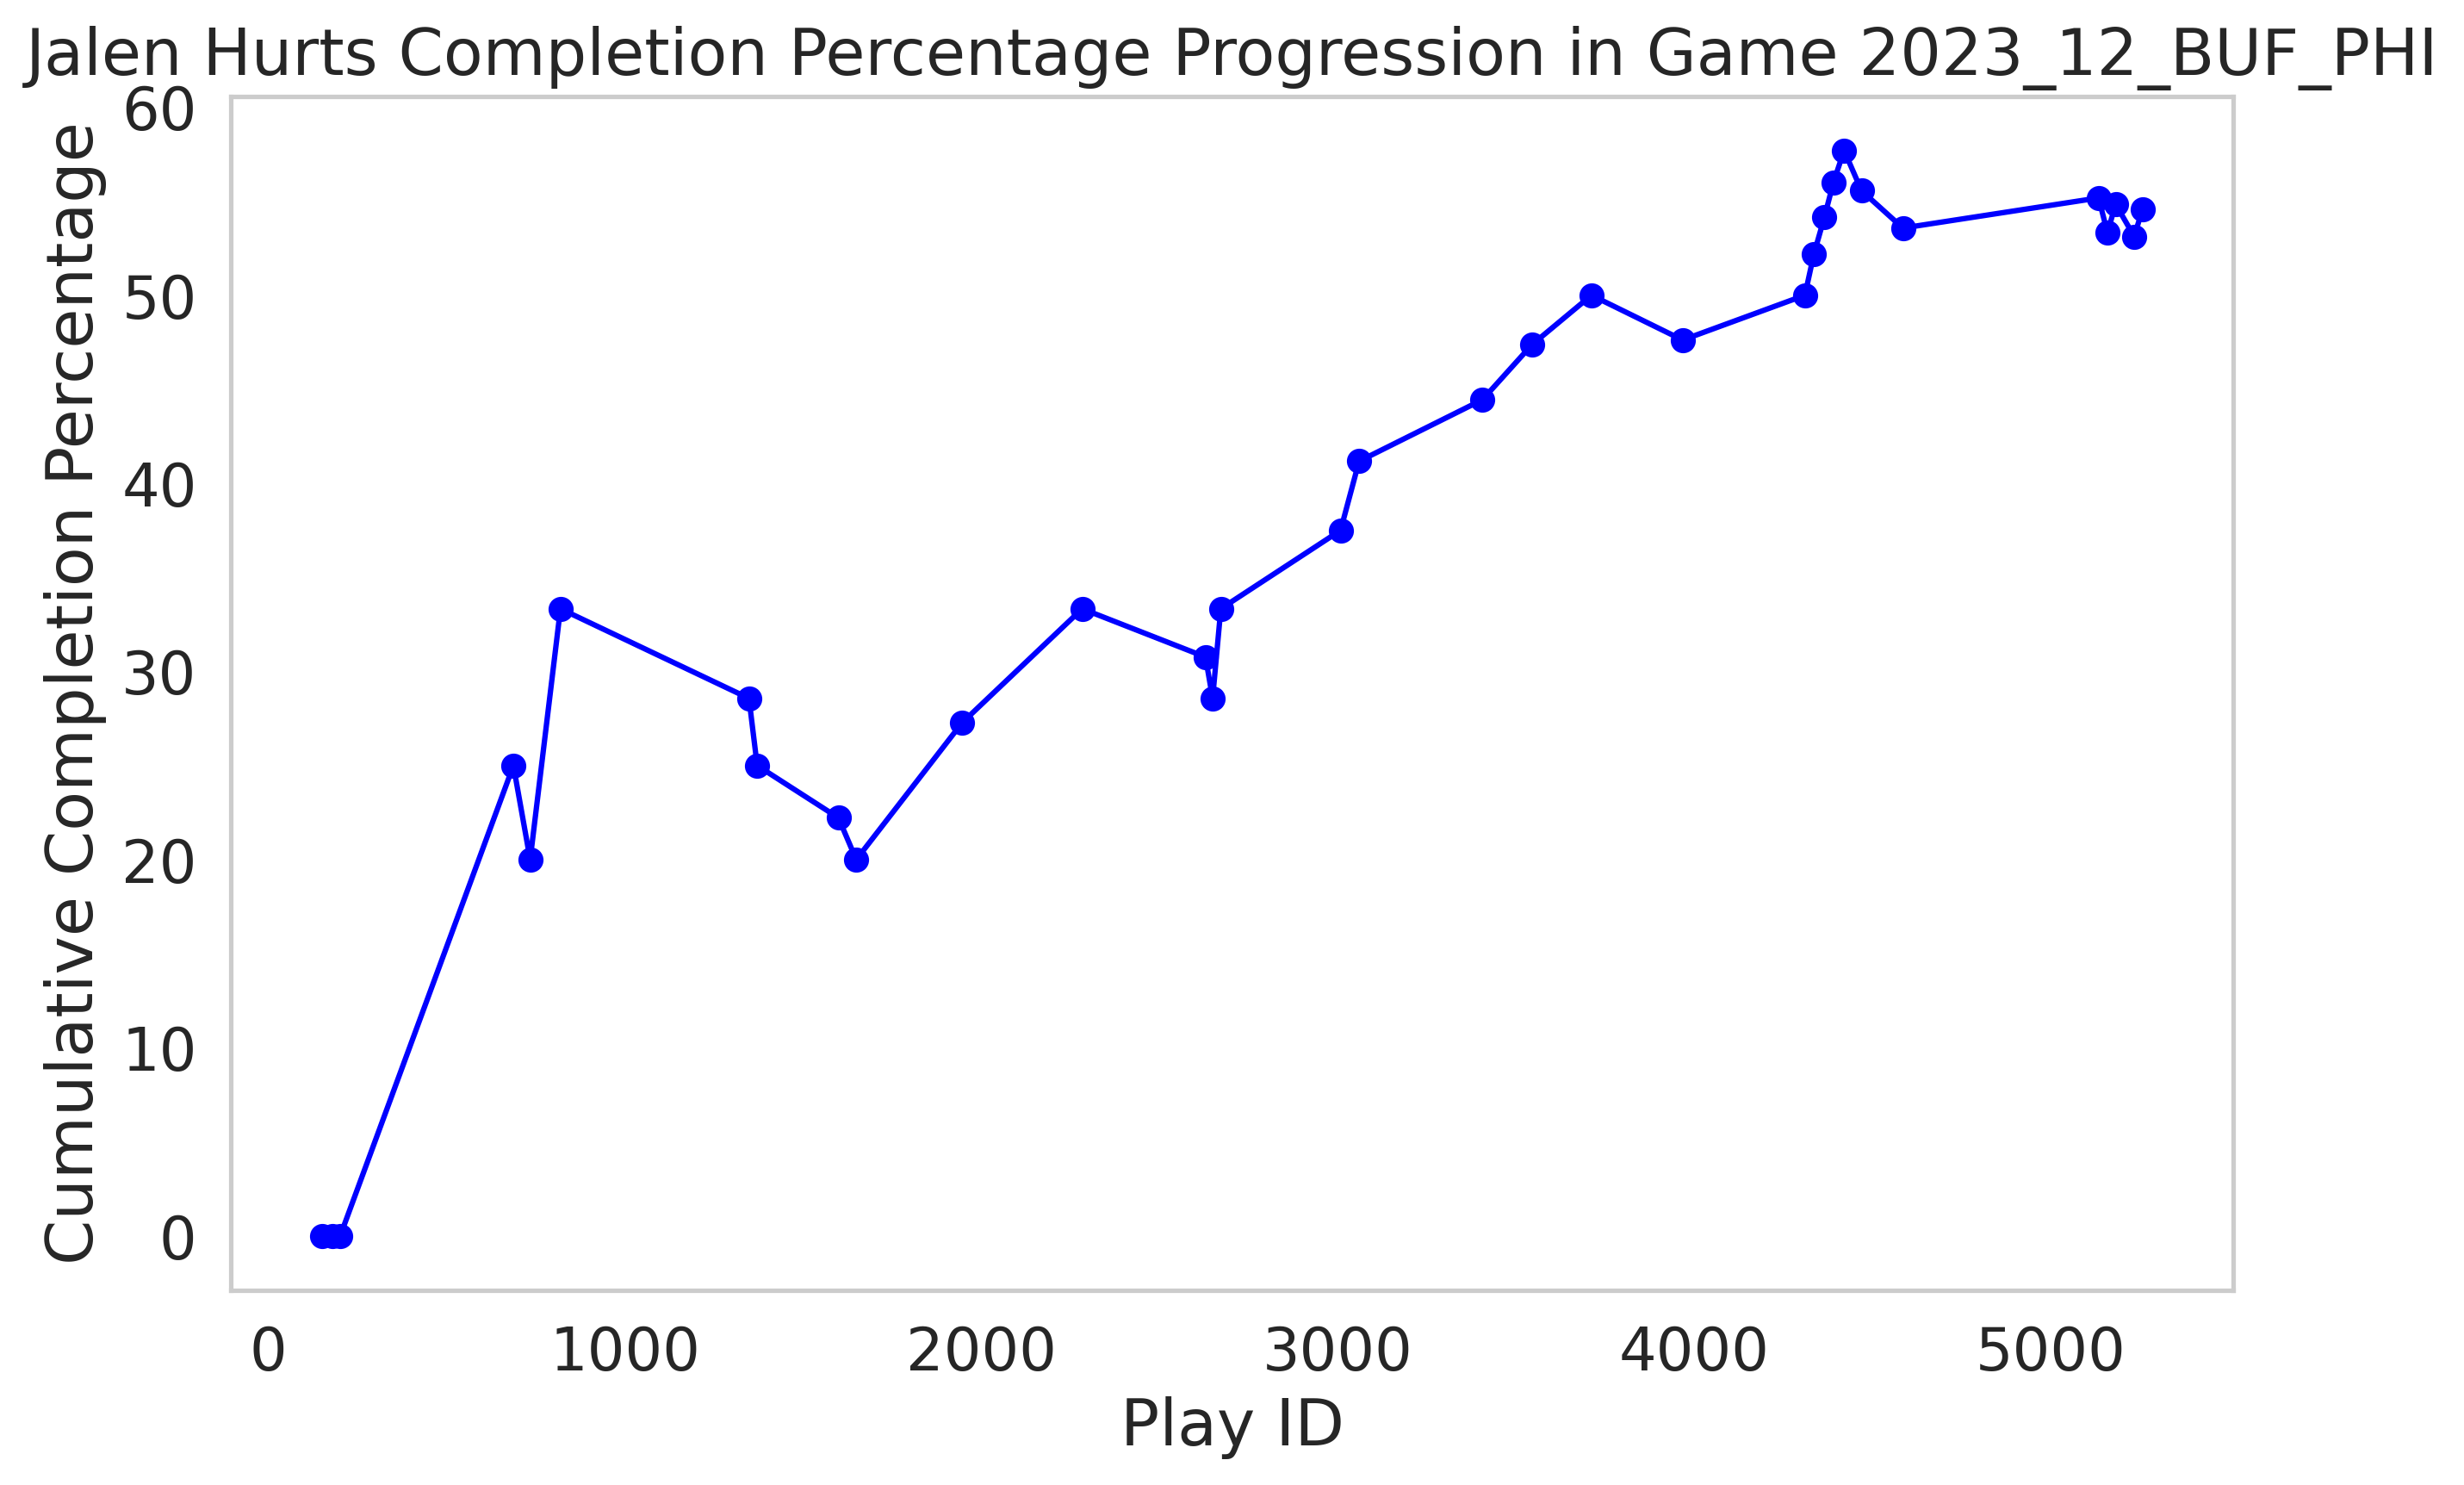

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(game_data['play_id'], game_data['completion_percentage'], marker='o', linestyle='-', color='blue')
plt.xlabel('Play ID')
plt.ylabel('Cumulative Completion Percentage')
plt.title('Jalen Hurts Completion Percentage Progression in Game 2023_12_BUF_PHI')
plt.grid()
plt.show()


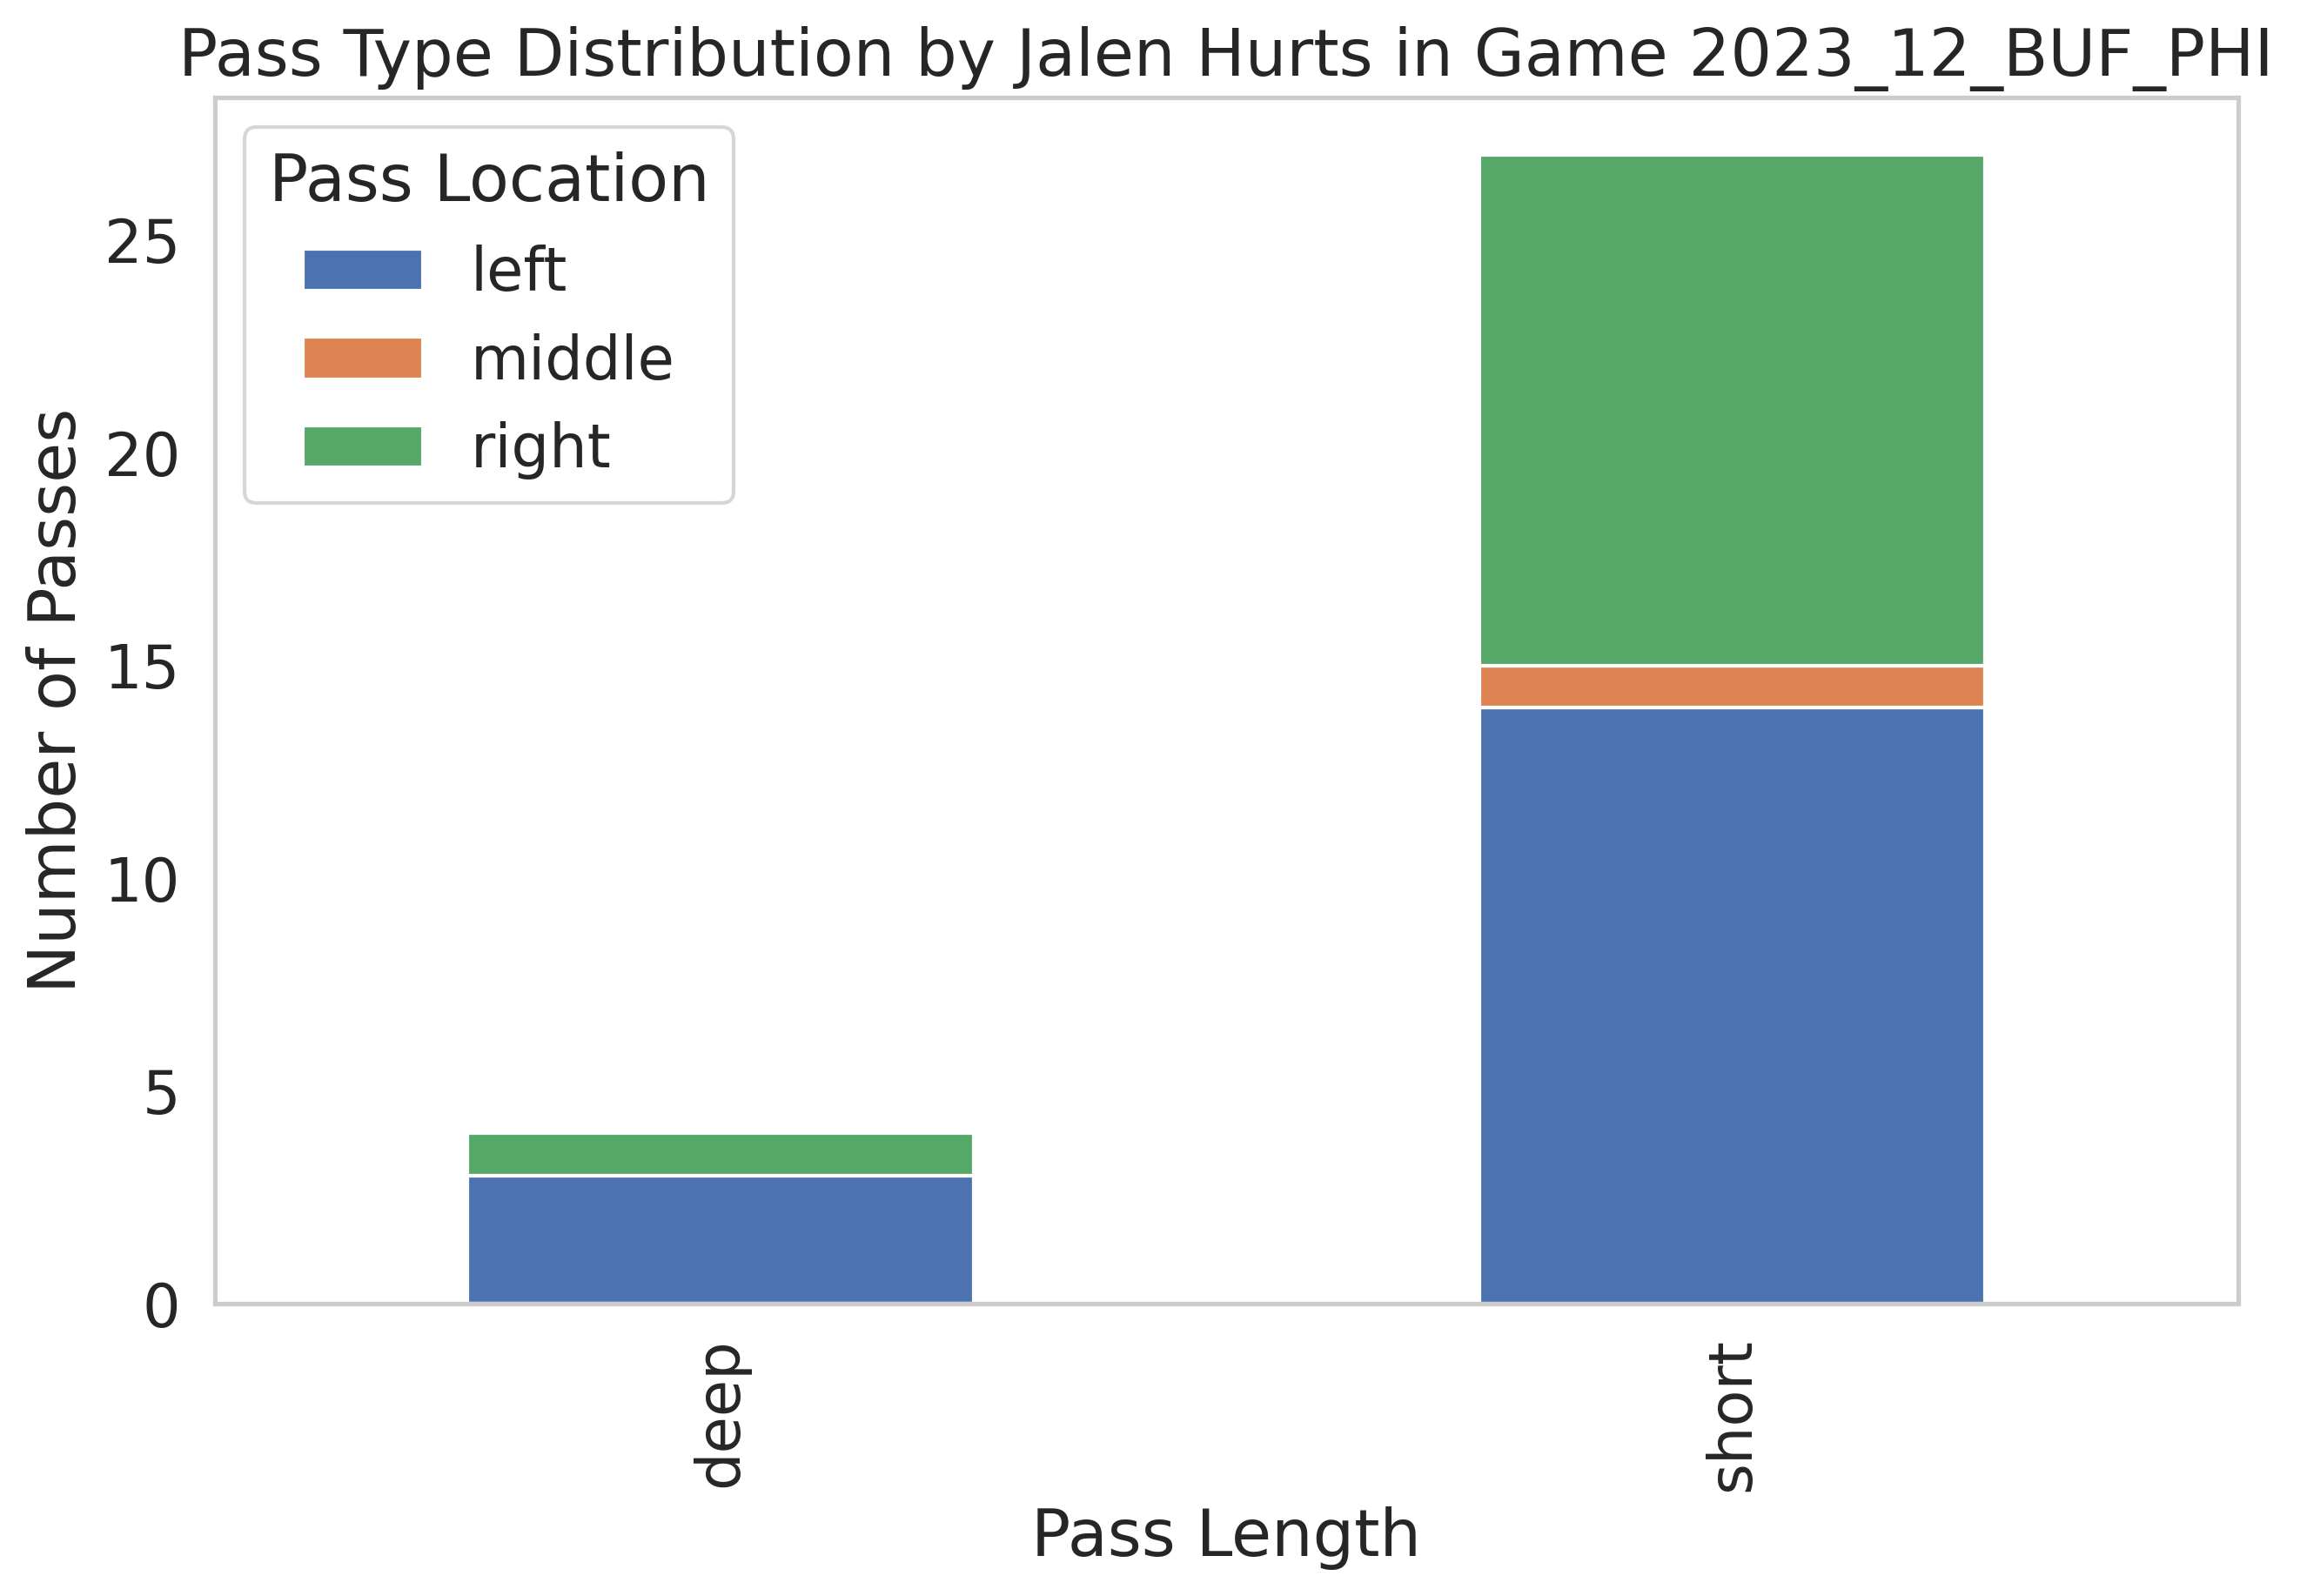

In [19]:
pass_types = game_data.groupby(['pass_length', 'pass_location']).size().unstack(fill_value=0)

pass_types.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Pass Length')
plt.ylabel('Number of Passes')
plt.title('Pass Type Distribution by Jalen Hurts in Game 2023_12_BUF_PHI')
plt.legend(title='Pass Location')
plt.grid()
plt.show()


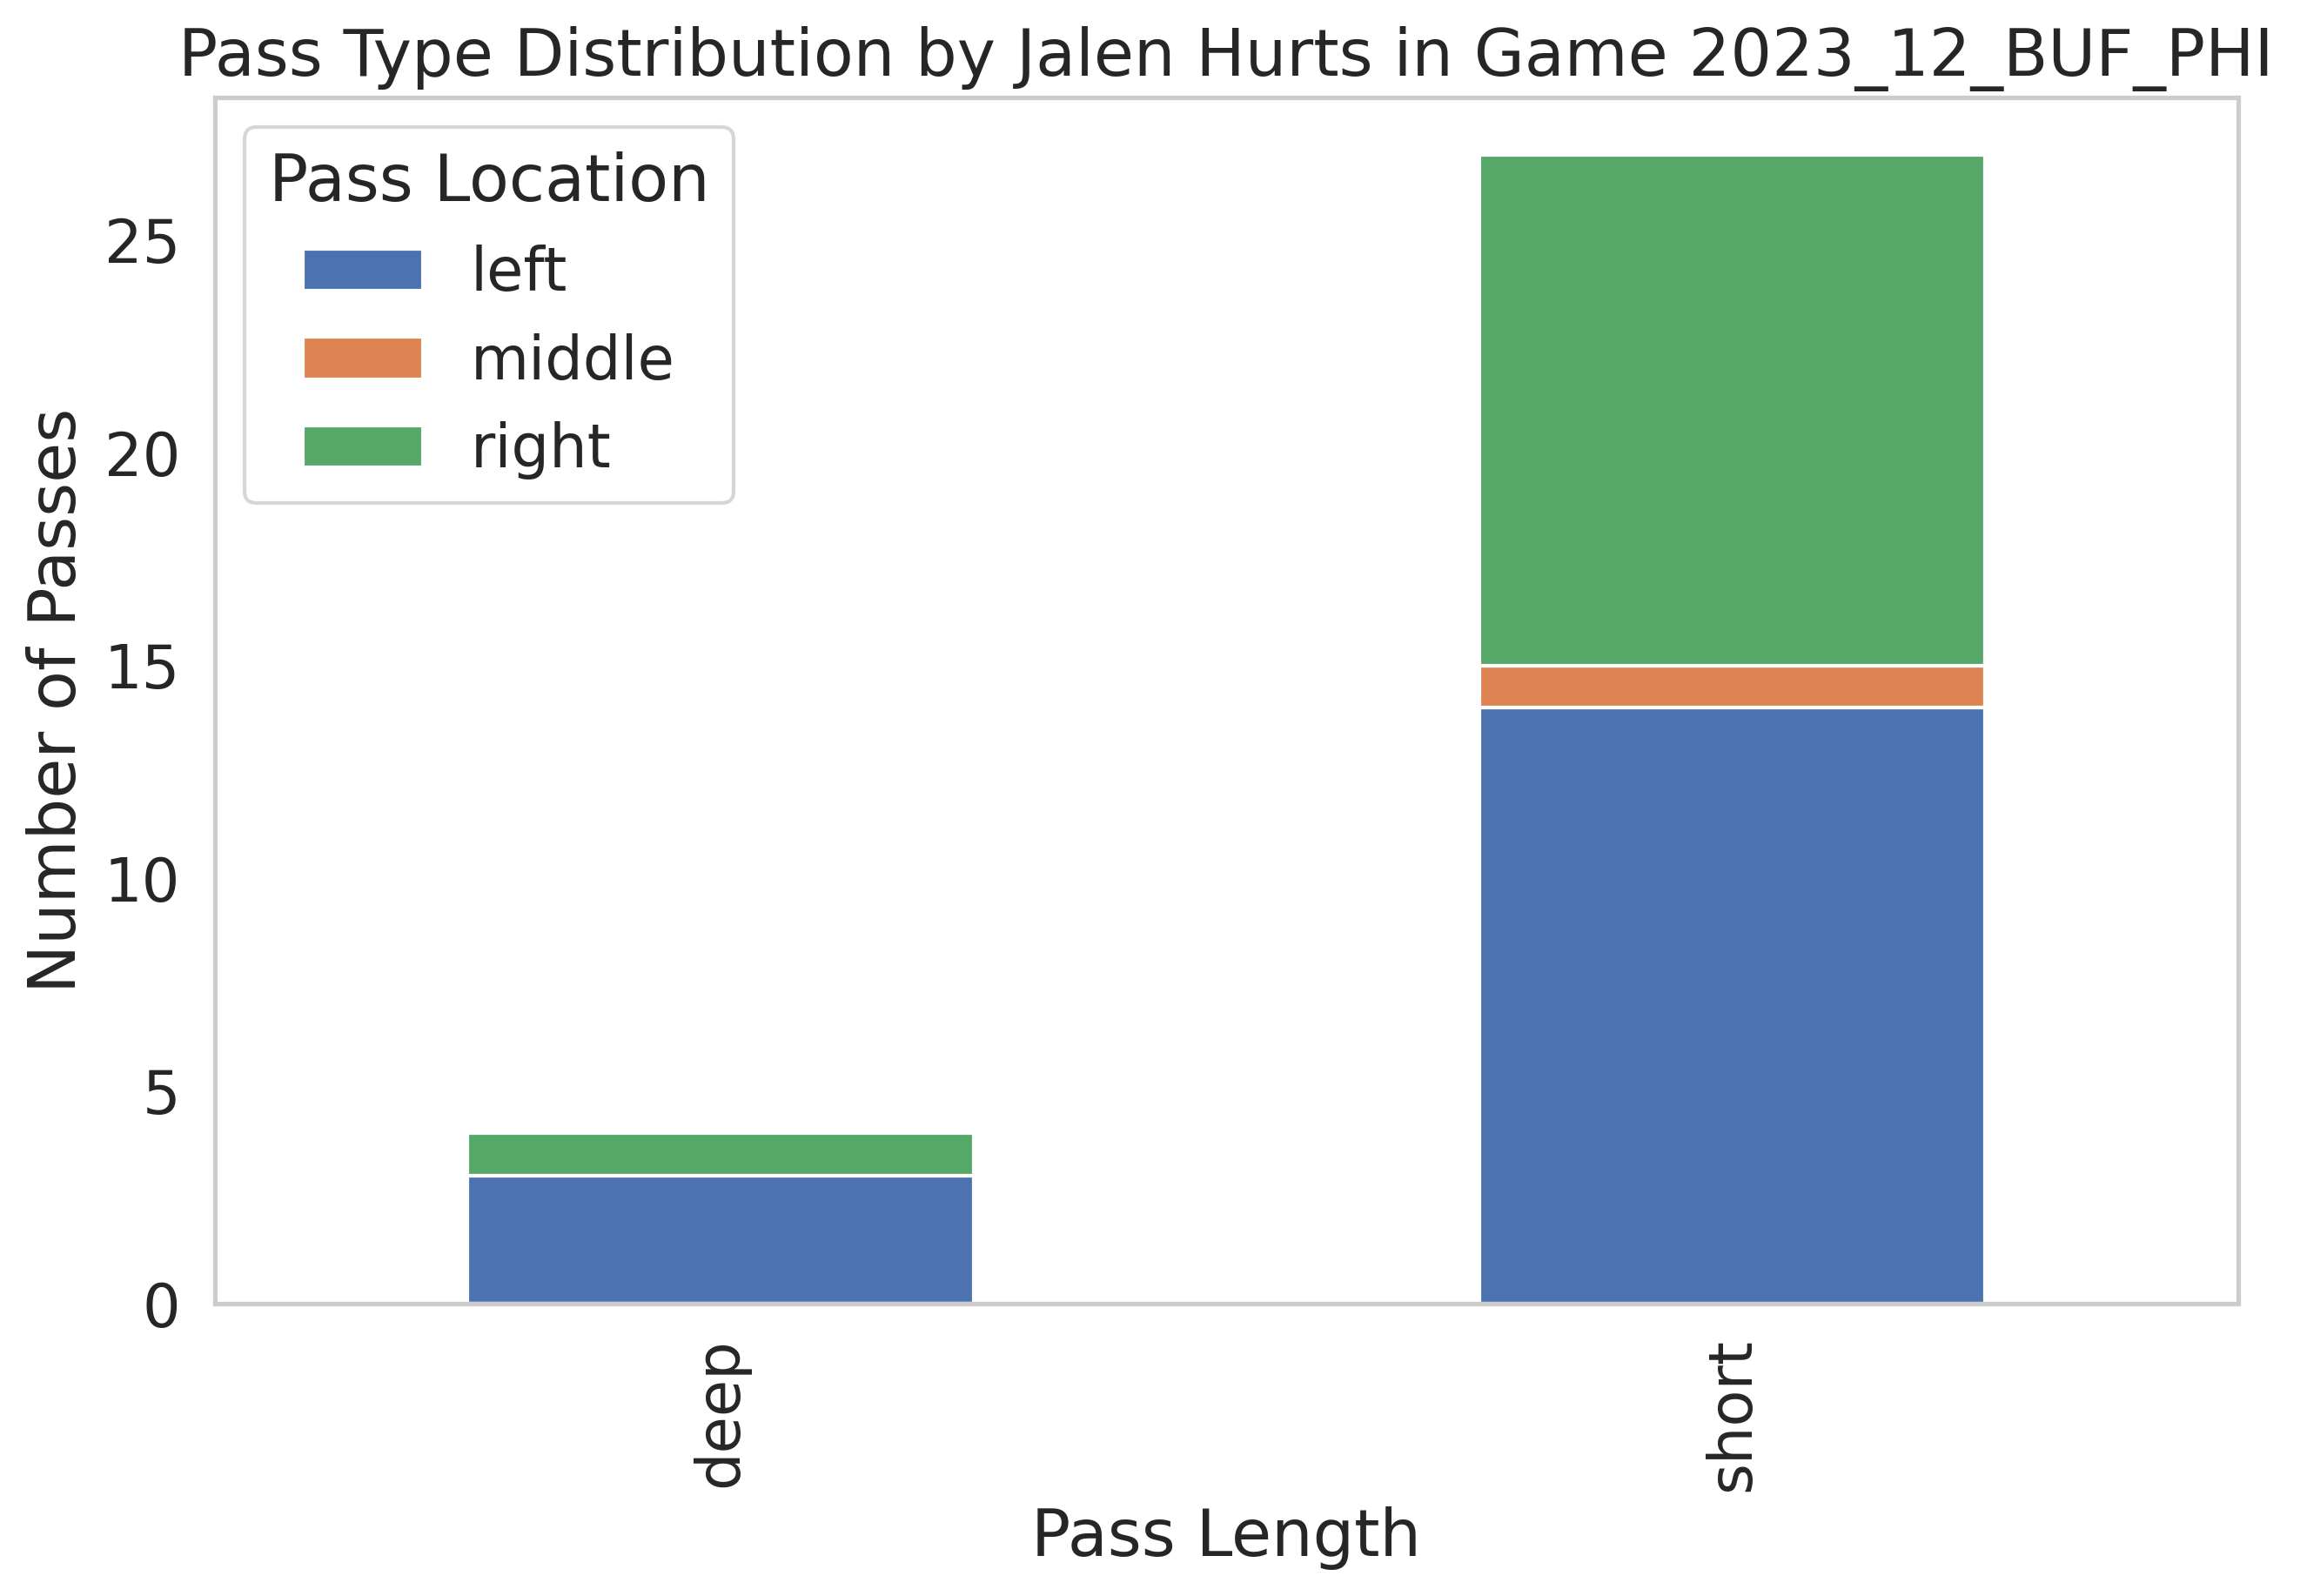

In [20]:
pass_types = game_data.groupby(['pass_length', 'pass_location']).size().unstack(fill_value=0)

pass_types.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Pass Length')
plt.ylabel('Number of Passes')
plt.title('Pass Type Distribution by Jalen Hurts in Game 2023_12_BUF_PHI')
plt.legend(title='Pass Location')
plt.grid()
plt.show()


In [21]:
summary_table = {
    'Total Attempts': game_data['pass_attempt'].sum(),
    'Completions': game_data['complete_pass'].sum(),
    'Completion %': game_data['completion_percentage'].iloc[-1],
    'Total Yards': game_data['yards_gained'].sum(),
    'Average Yards per Attempt': game_data['yards_gained'].mean()
}

summary_df = pd.DataFrame.from_dict(summary_table, orient='index', columns=['Value'])

# Display the table
print(summary_df)


                                Value
Total Attempts              33.000000
Completions                 18.000000
Completion %                54.545455
Total Yards                193.000000
Average Yards per Attempt    5.848485


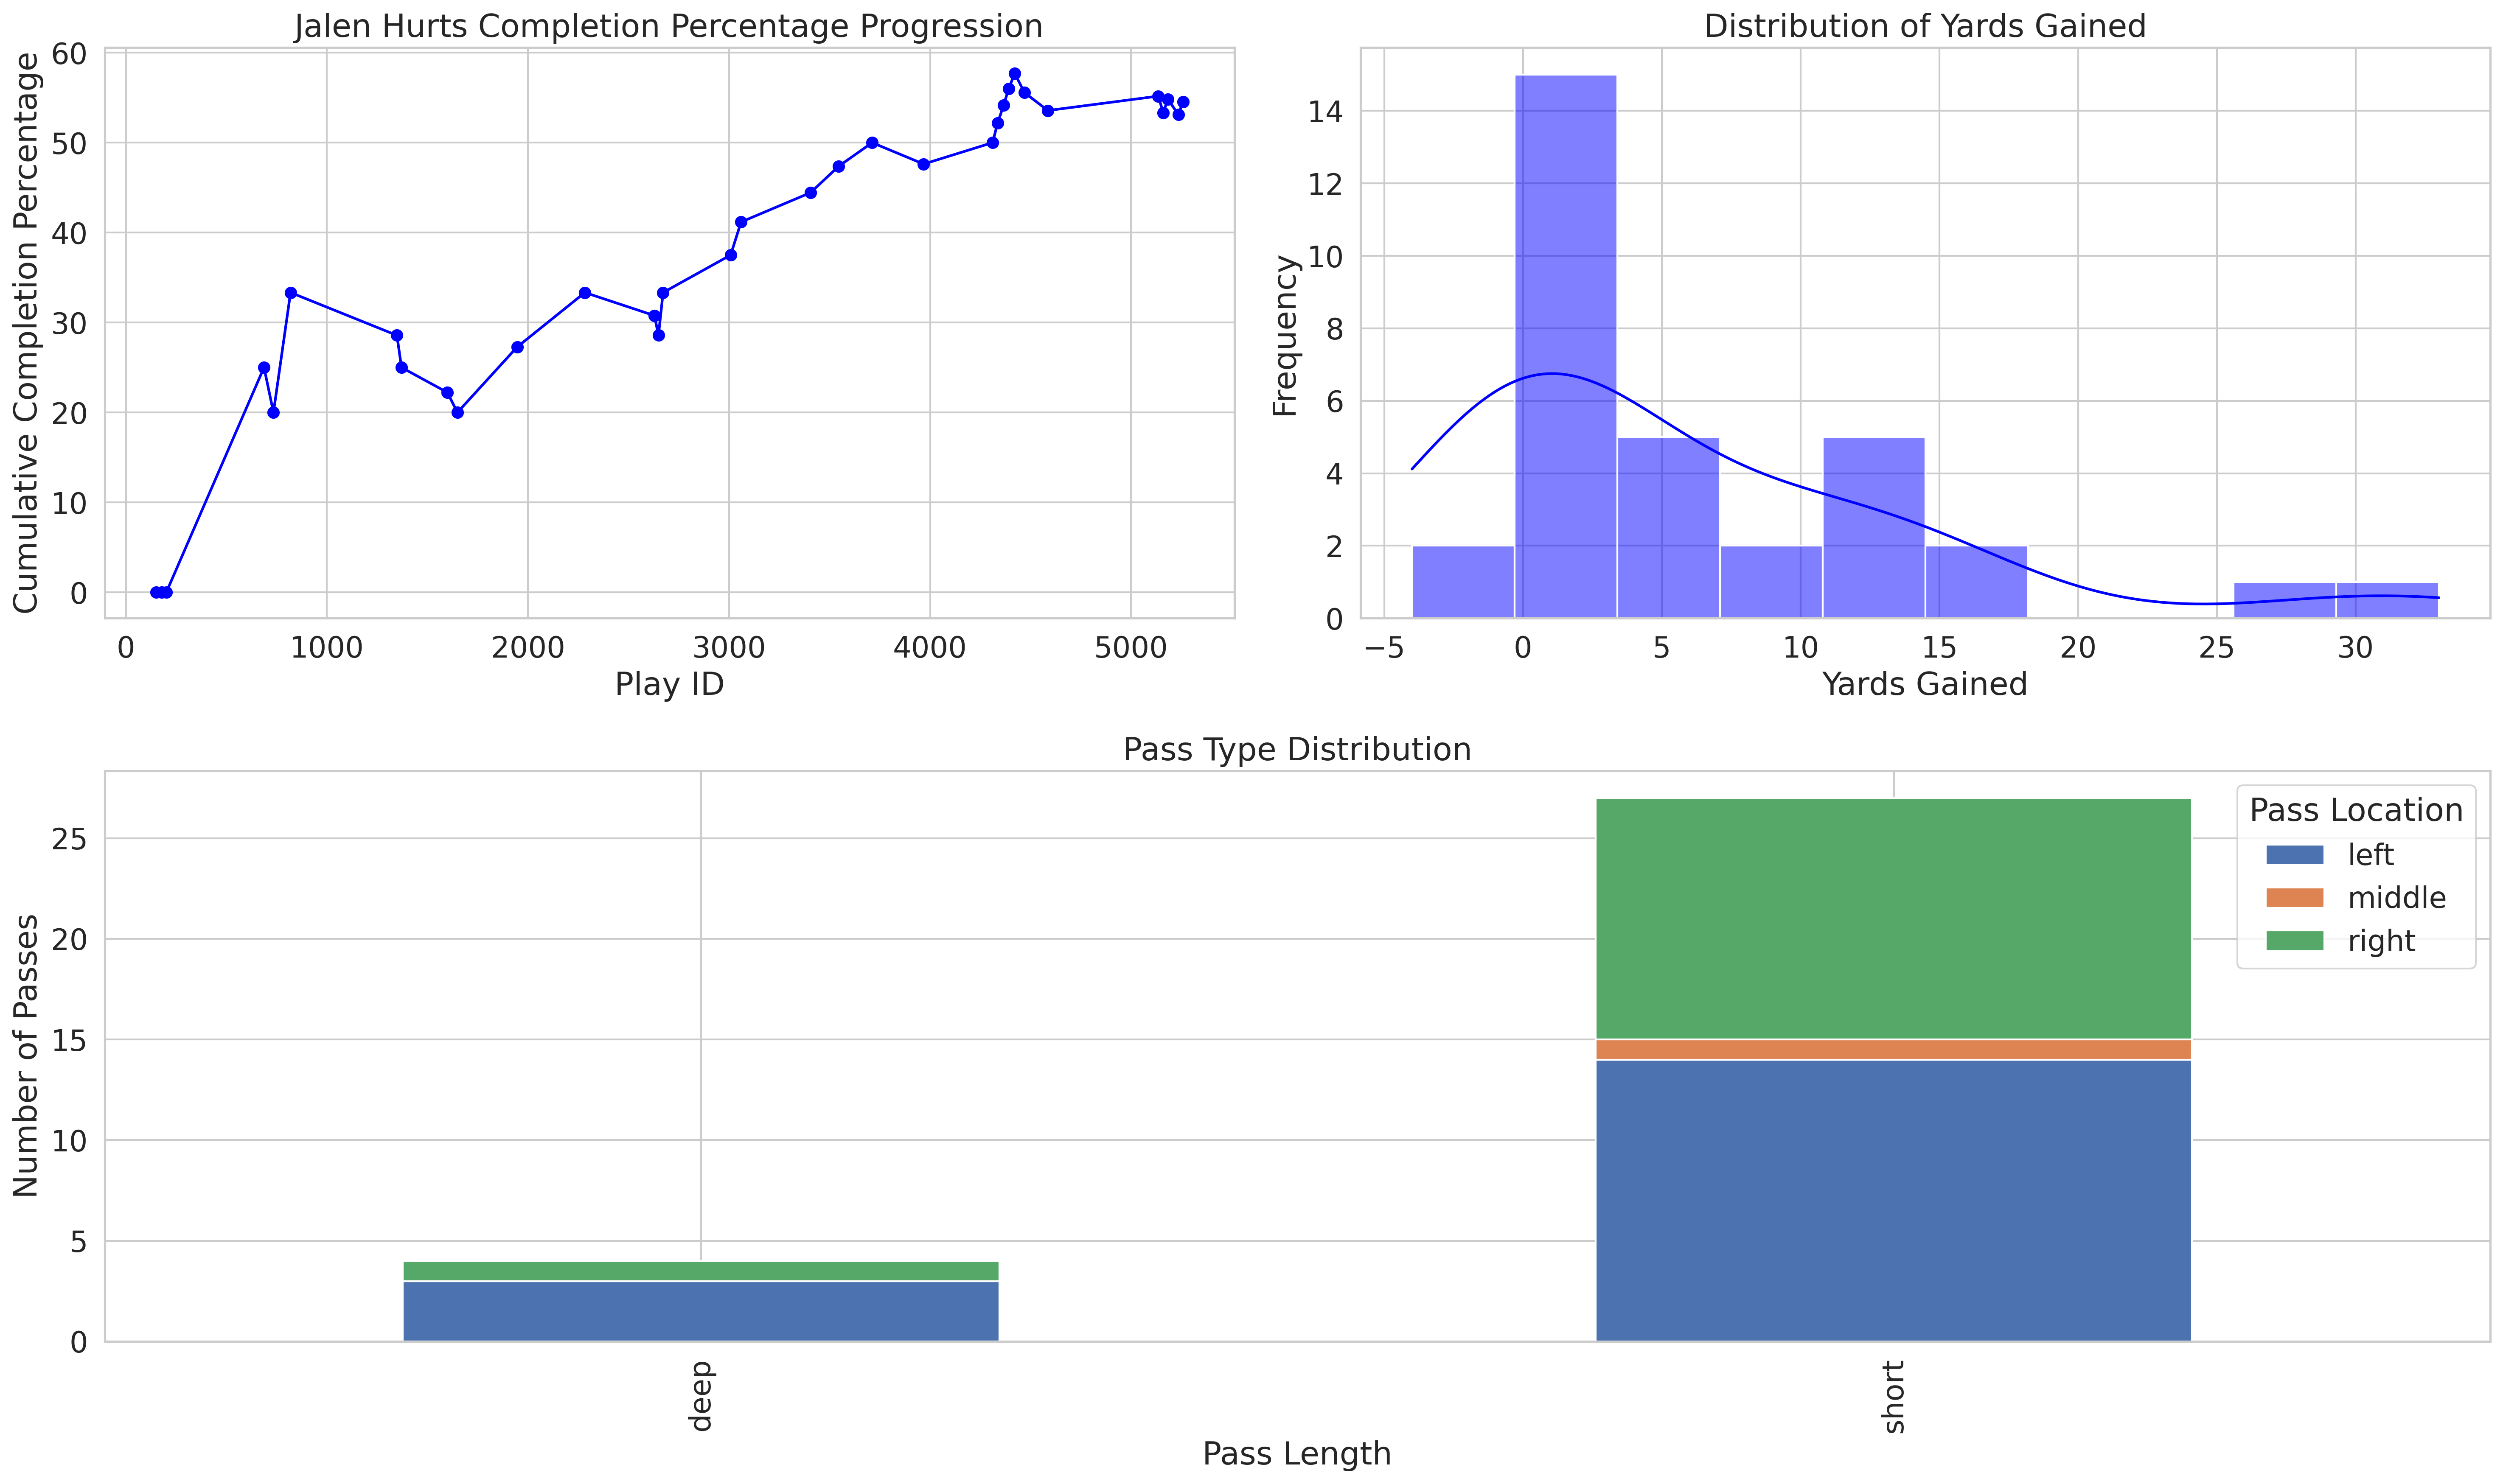

In [22]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# Completion Percentage Progression Plot
ax1.plot(game_data['play_id'], game_data['completion_percentage'], marker='o', linestyle='-', color='blue')
ax1.set_xlabel('Play ID')
ax1.set_ylabel('Cumulative Completion Percentage')
ax1.set_title('Jalen Hurts Completion Percentage Progression')

# Yards Gained Distribution Plot
sns.histplot(game_data['yards_gained'], bins=10, kde=True, color='blue', ax=ax2)
ax2.set_xlabel('Yards Gained')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Yards Gained')

# Pass Type Analysis
pass_types.plot(kind='bar', stacked=True, ax=ax3)
ax3.set_xlabel('Pass Length')
ax3.set_ylabel('Number of Passes')
ax3.set_title('Pass Type Distribution')
ax3.legend(title='Pass Location')

plt.tight_layout()
plt.show()


C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_29940\2376625692.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['cumulative_completions'] = game_data['complete_pass'].cumsum()
C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_29940\2376625692.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['cumulative_attempts'] = game_data['pass_attempt'].cumsum()
C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_29940\2376625692.py:27: SettingWithCopyWarning: 
A value is try

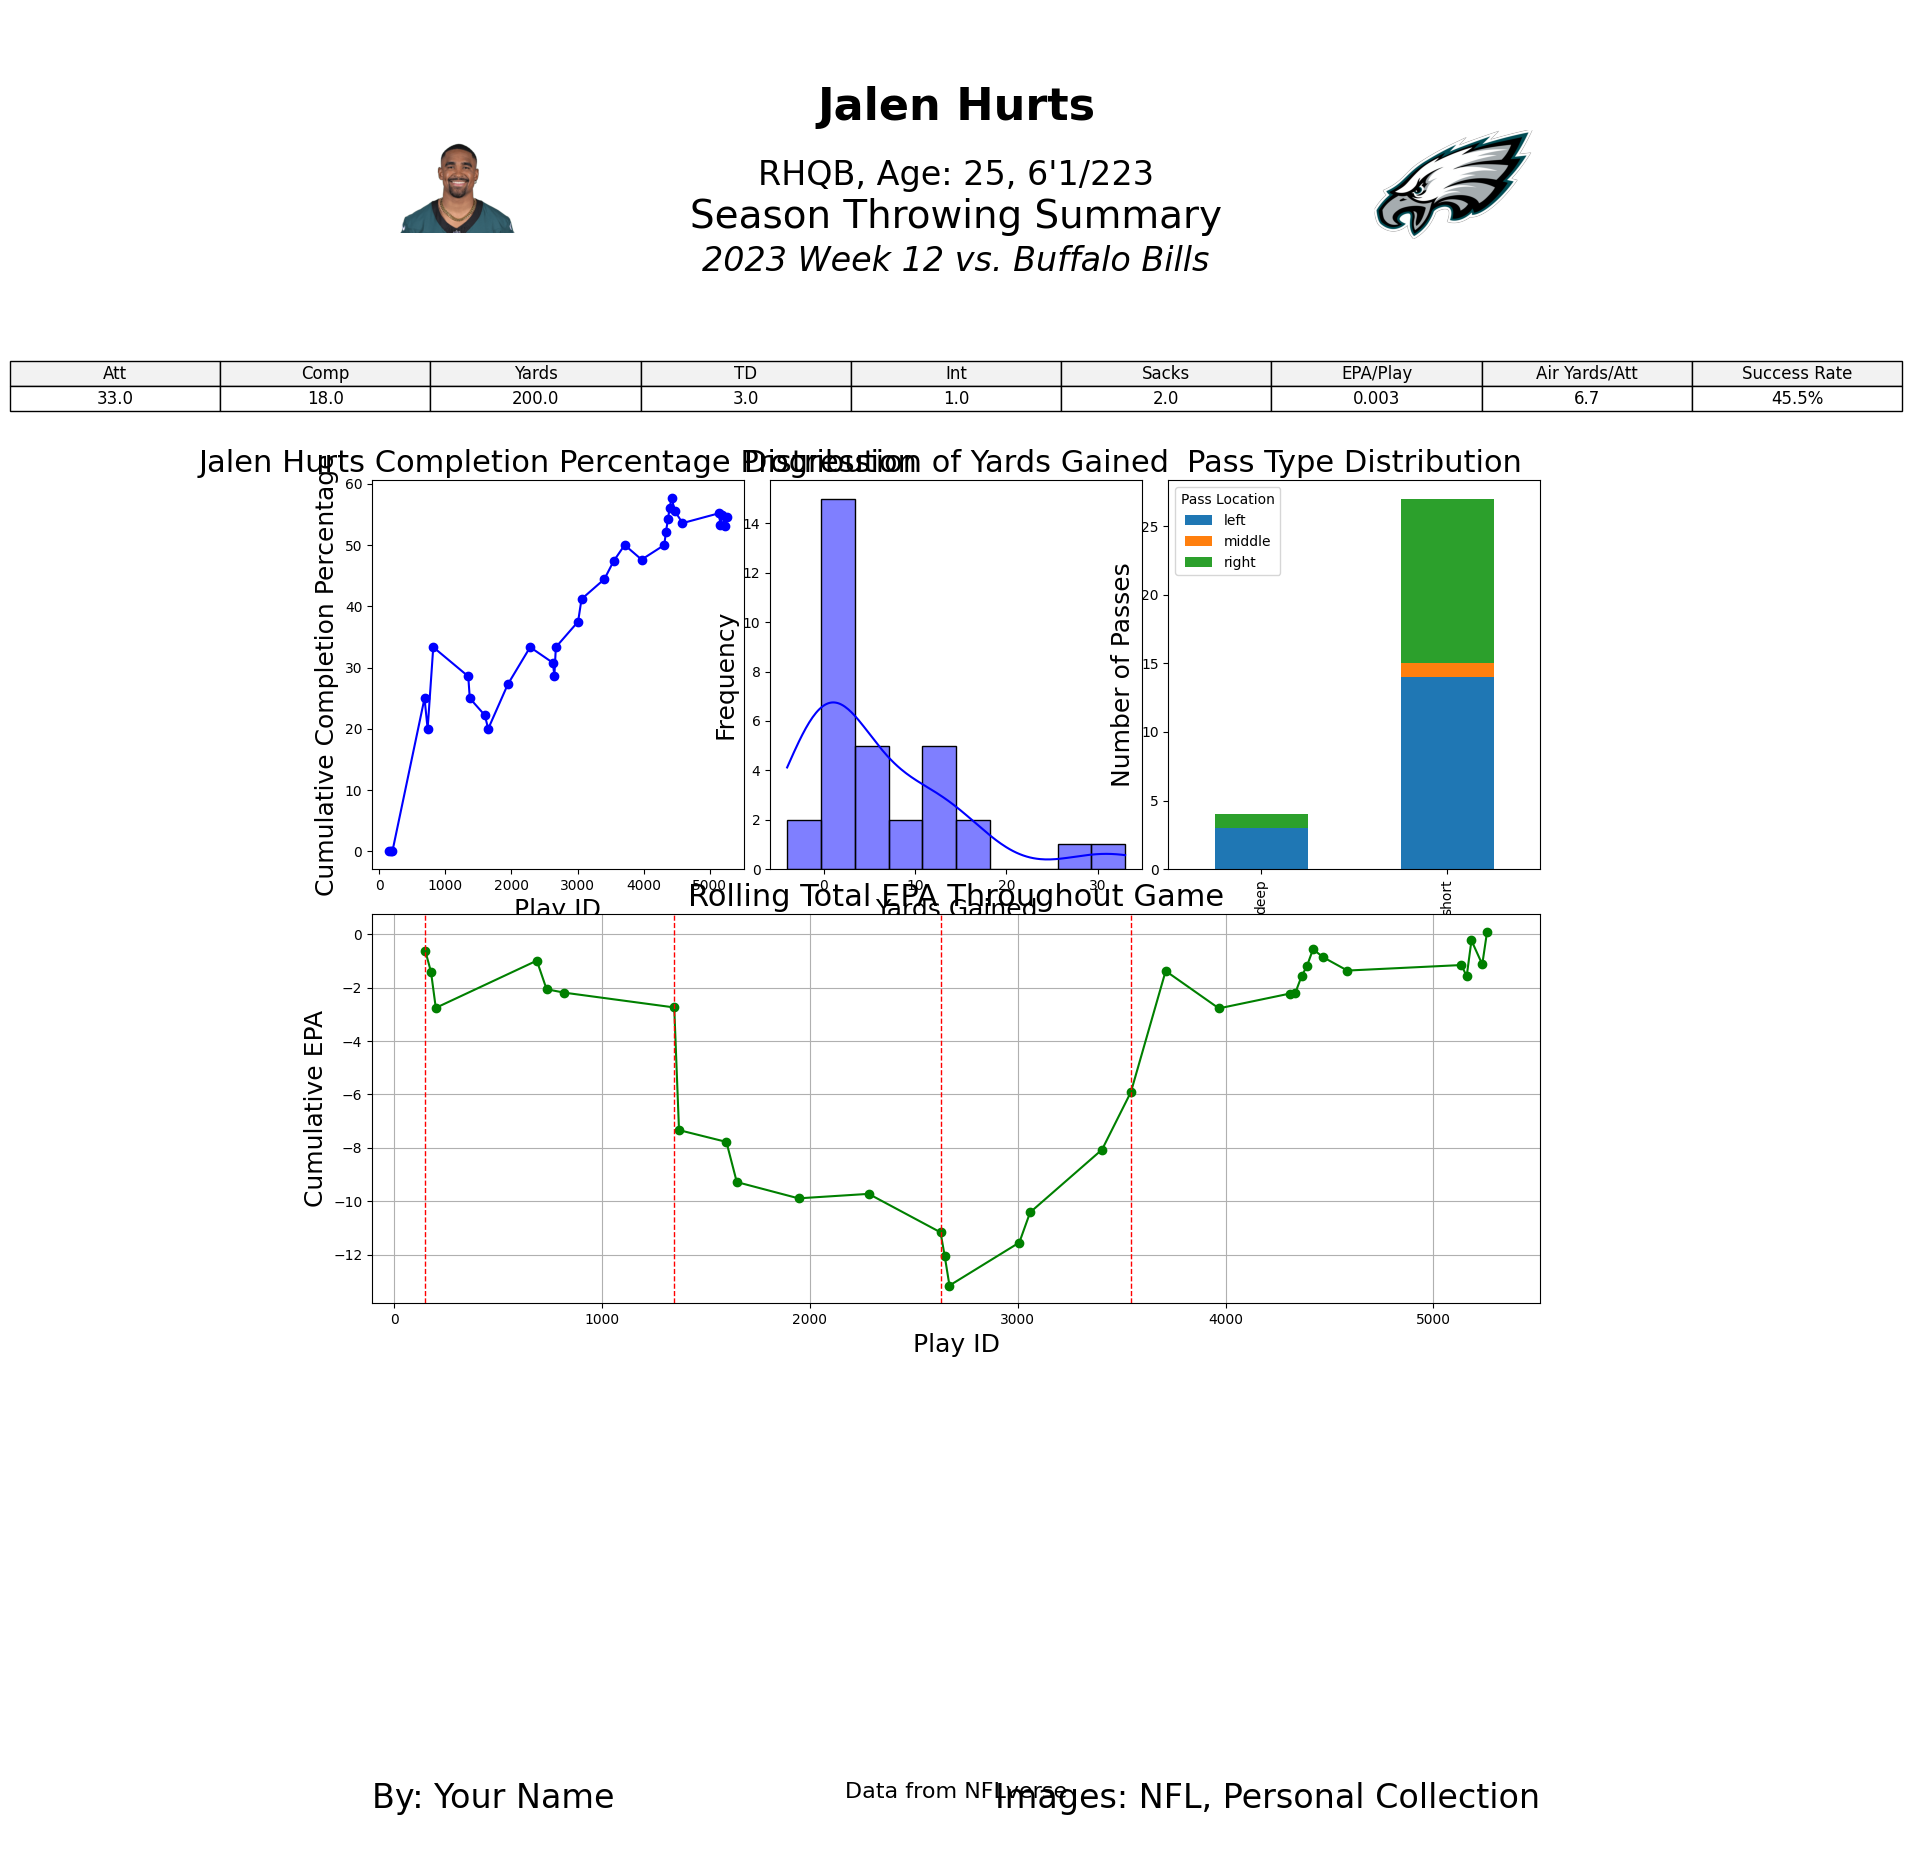

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from PIL import Image

# Define the year and load the data
YEAR = 2023
url = f'https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_{YEAR}.csv.gz'
data = pd.read_csv(url, compression='gzip', low_memory=False)

# Set options for displaying dataframes
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 400)

# Filter by team (Philadelphia Eagles) and quarterback Jalen Hurts
filtered_df = data[(data['home_team'] == 'PHI') | (data['away_team'] == 'PHI')]
filtered_hurts = filtered_df[filtered_df['passer_player_name'] == 'J.Hurts']

# Filter data for a specific game (e.g., 2023_12_BUF_PHI)
game_data = filtered_hurts[filtered_hurts['game_id'] == '2023_12_BUF_PHI']

# Calculate cumulative completions and attempts
game_data['cumulative_completions'] = game_data['complete_pass'].cumsum()
game_data['cumulative_attempts'] = game_data['pass_attempt'].cumsum()
game_data['cumulative_completion_percentage'] = (game_data['cumulative_completions'] / game_data['cumulative_attempts']) * 100

# Additional metrics calculations
game_data['epa_per_play'] = game_data['epa']
epa_per_play = round(game_data['epa_per_play'].mean(), 3)  # Show 3 decimal places

air_yards_per_attempt = round(game_data['air_yards'].sum() / game_data['pass_attempt'].sum(), 2)
success_rate = round(game_data[game_data['epa'] > 0].shape[0] / game_data.shape[0] * 100, 1)

# Calculate rolling total EPA
game_data['rolling_total_epa'] = game_data['epa'].cumsum()

# Determine play IDs for quarter lines using game_seconds_remaining
# Assuming standard NFL game times (15-minute quarters and overtime if applicable)
quarter_end_times = [3600, 2700, 1800, 900, 0]  # End times for Q1, Q2, Q3, Q4, OT (seconds)
quarter_positions = []

for end_time in quarter_end_times:
    try:
        play_id = game_data[game_data['game_seconds_remaining'] <= end_time].iloc[0]['play_id']
        quarter_positions.append(play_id)
    except IndexError:
        continue

# Prepare data for Pass Type Distribution
pass_types = game_data.groupby(['pass_length', 'pass_location']).size().unstack(fill_value=0)

# Summary Table
summary_table = {
    'Att': [game_data['pass_attempt'].sum()],
    'Comp': [game_data['complete_pass'].sum()],
    'Yards': [game_data['passing_yards'].sum()],
    'TD': [game_data['pass_touchdown'].sum()],
    'Int': [game_data['interception'].sum()],
    'Sacks': [game_data['sack'].sum()],
    'EPA/Play': [epa_per_play],
    'Air Yards/Att': [air_yards_per_attempt],
    'Success Rate': [f"{success_rate}%"]
}
summary_df = pd.DataFrame.from_dict(summary_table)

# Load images
headshot_path = r'C:\Users\RaymondCarpenter\Documents\GitHub\14thstreetanalytics\throwing_summary\hurts_headshot.png'
logo_path = r'C:\Users\RaymondCarpenter\Documents\GitHub\14thstreetanalytics\throwing_summary\philadelphia-eagles-logo.png'
headshot = Image.open(headshot_path)
logo = Image.open(logo_path)

# Function to create the Jalen Hurts dashboard
def jalen_hurts_dashboard(game_data: pd.DataFrame, pass_types: pd.DataFrame, headshot: Image, logo: Image, summary_df: pd.DataFrame, quarter_positions):
    # Create a 16 by 24 figure (narrower and taller)
    fig = plt.figure(figsize=(16, 24))

    # Create a gridspec layout with 8 columns and 7 rows
    gs = gridspec.GridSpec(7, 8,
                           height_ratios=[2, 20, 9, 36, 36, 36, 7],
                           width_ratios=[1, 18, 18, 18, 18, 18, 18, 1])

    # Define the positions of each subplot in the grid
    ax_headshot = fig.add_subplot(gs[1, 1:2])
    ax_bio = fig.add_subplot(gs[1, 2:6])
    ax_logo = fig.add_subplot(gs[1, 6:7])

    ax_summary_table = fig.add_subplot(gs[2, 1:7])

    ax_completion_plot = fig.add_subplot(gs[3, 1:3])
    ax_yards_dist = fig.add_subplot(gs[3, 3:5])
    ax_pass_type = fig.add_subplot(gs[3, 5:7])

    ax_rolling_epa = fig.add_subplot(gs[4, 1:7])  # New axis for rolling EPA plot

    ax_footer = fig.add_subplot(gs[-1, 1:7])
    ax_header = fig.add_subplot(gs[0, 1:7])
    ax_left = fig.add_subplot(gs[:, 0])
    ax_right = fig.add_subplot(gs[:, -1])

    # Hide axes for footer, header, left, and right
    ax_footer.axis('off')
    ax_header.axis('off')
    ax_left.axis('off')
    ax_right.axis('off')

    # Plot headshot and logo with increased size
    ax_headshot.imshow(headshot)
    ax_headshot.axis('off')
    ax_logo.imshow(logo)
    ax_logo.axis('off')

    # Biographical Information with correct title placement
    ax_bio.text(0.5, 0.8, 'Jalen Hurts', fontsize=32, ha='center', fontweight='bold')
    ax_bio.text(0.5, 0.5, 'RHQB, Age: 25, 6\'1/223', fontsize=24, ha='center')
    ax_bio.text(0.5, 0.3, 'Season Throwing Summary', fontsize=28, ha='center')
    ax_bio.text(0.5, 0.1, '2023 Week 12 vs. Buffalo Bills', fontsize=24, ha='center', fontstyle='italic')
    ax_bio.axis('off')

    # Summary Table Plot
    ax_summary_table.axis('off')
    table = ax_summary_table.table(cellText=summary_df.values,
                                   colLabels=summary_df.columns,
                                   cellLoc='center',
                                   loc='center',
                                   colColours=['#f2f2f2'] * len(summary_df.columns),
                                   colWidths=[0.12] * len(summary_df.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 1.5)

    # Completion Percentage Progression Plot
    ax_completion_plot.plot(game_data['play_id'], game_data['cumulative_completion_percentage'], marker='o', linestyle='-', color='blue')
    ax_completion_plot.set_xlabel('Play ID', fontdict={'size': 18})
    ax_completion_plot.set_ylabel('Cumulative Completion Percentage', fontdict={'size': 18})
    ax_completion_plot.set_title('Jalen Hurts Completion Percentage Progression', fontdict={'size': 22})

    # Yards Gained Distribution Plot
    sns.histplot(game_data['yards_gained'], bins=10, kde=True, color='blue', ax=ax_yards_dist)
    ax_yards_dist.set_xlabel('Yards Gained', fontdict={'size': 18})
    ax_yards_dist.set_ylabel('Frequency', fontdict={'size': 18})
    ax_yards_dist.set_title('Distribution of Yards Gained', fontdict={'size': 22})

    # Pass Type Analysis
    pass_types.plot(kind='bar', stacked=True, ax=ax_pass_type)
    ax_pass_type.set_xlabel('Pass Length', fontdict={'size': 18})
    ax_pass_type.set_ylabel('Number of Passes', fontdict={'size': 18})
    ax_pass_type.set_title('Pass Type Distribution', fontdict={'size': 22})
    ax_pass_type.legend(title='Pass Location')

    # Rolling Total EPA Plot
    ax_rolling_epa.plot(game_data['play_id'], game_data['rolling_total_epa'], marker='o', linestyle='-', color='green')
    for pos in quarter_positions:
        ax_rolling_epa.axvline(x=pos, color='red', linestyle='--', linewidth=1)
    ax_rolling_epa.set_xlabel('Play ID', fontdict={'size': 18})
    ax_rolling_epa.set_ylabel('Cumulative EPA', fontdict={'size': 18})
    ax_rolling_epa.set_title('Rolling Total EPA Throughout Game', fontdict={'size': 22})
    ax_rolling_epa.grid(True)

    # Footer
    ax_footer.text(0, 1, 'By: Your Name', ha='left', va='top', fontsize=24)
    ax_footer.text(0.5, 1, 'Data from NFLverse', ha='center', va='top', fontsize=16)
    ax_footer.text(1, 1, 'Images: NFL, Personal Collection', ha='right', va='top', fontsize=24)

    # Adjust the spacing between subplots
    plt.tight_layout(pad=4.0)

    # Show the figure
    plt.show()

# Call the dashboard function
jalen_hurts_dashboard(game_data, pass_types, headshot, logo, summary_df, quarter_positions)


C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_29940\3860567160.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['cumulative_completions'] = game_data['complete_pass'].cumsum()
C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_29940\3860567160.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['cumulative_attempts'] = game_data['pass_attempt'].cumsum()
C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_29940\3860567160.py:27: SettingWithCopyWarning: 
A value is try

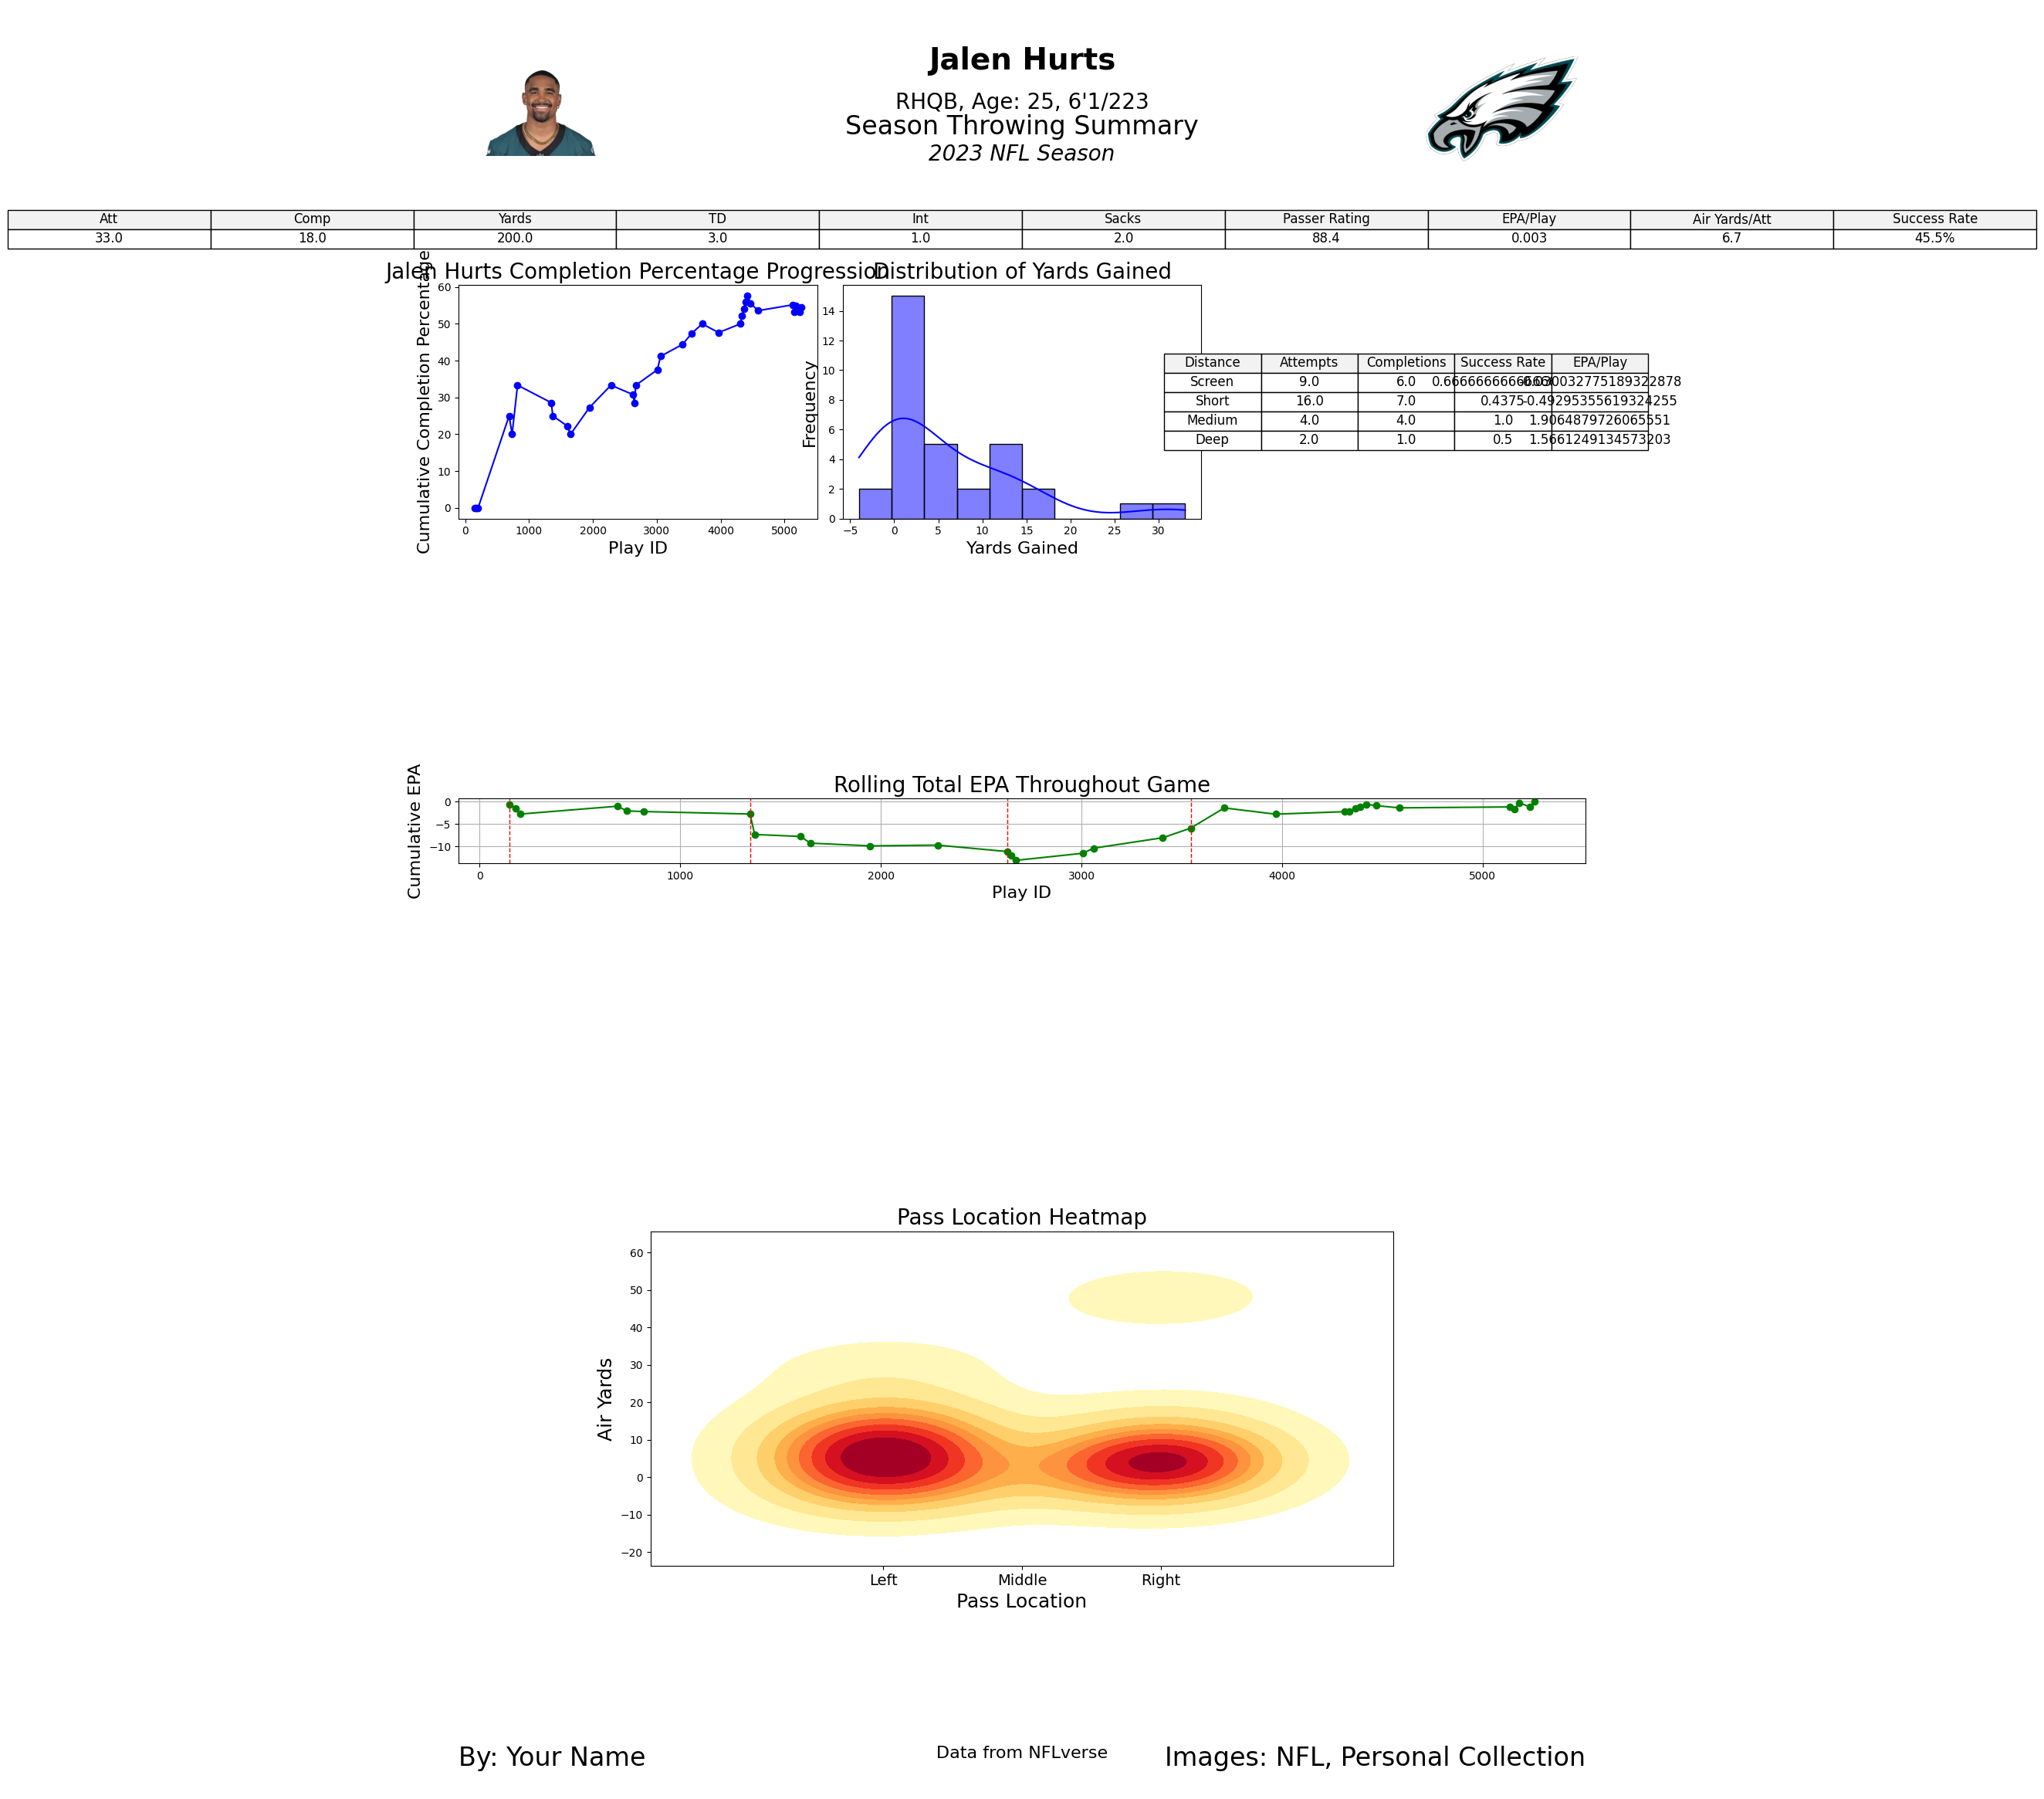

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from PIL import Image

# Define the year and load the data
YEAR = 2023
url = f'https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_{YEAR}.csv.gz'
data = pd.read_csv(url, compression='gzip', low_memory=False)

# Set options for displaying dataframes
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 400)

# Filter by team (Philadelphia Eagles) and quarterback Jalen Hurts
filtered_df = data[(data['home_team'] == 'PHI') | (data['away_team'] == 'PHI')]
filtered_hurts = filtered_df[filtered_df['passer_player_name'] == 'J.Hurts']

# Filter data for a specific game (e.g., 2023_12_BUF_PHI)
game_data = filtered_hurts[filtered_hurts['game_id'] == '2023_12_BUF_PHI']

# Calculate cumulative completions and attempts
game_data['cumulative_completions'] = game_data['complete_pass'].cumsum()
game_data['cumulative_attempts'] = game_data['pass_attempt'].cumsum()
game_data['cumulative_completion_percentage'] = (game_data['cumulative_completions'] / game_data['cumulative_attempts']) * 100

# Additional metrics calculations
game_data['epa_per_play'] = game_data['epa']
epa_per_play = round(game_data['epa_per_play'].mean(), 3)  # Show 3 decimal places

air_yards_per_attempt = round(game_data['air_yards'].sum() / game_data['pass_attempt'].sum(), 2)
success_rate = round(game_data[game_data['epa'] > 0].shape[0] / game_data.shape[0] * 100, 1)

# Calculate passer rating
completions = game_data['complete_pass'].sum()
attempts = game_data['pass_attempt'].sum()
yards = game_data['passing_yards'].sum()
touchdowns = game_data['pass_touchdown'].sum()
interceptions = game_data['interception'].sum()

if attempts > 0:
    comp_pct = completions / attempts
    avg_yards = yards / attempts
    td_pct = touchdowns / attempts
    int_pct = interceptions / attempts

    passer_rating = (comp_pct * 5 + avg_yards * 0.25 + td_pct * 20 - int_pct * 25) / 6 * 100
    passer_rating = round(passer_rating, 1)
else:
    passer_rating = 0

# Calculate rolling total EPA
game_data['rolling_total_epa'] = game_data['epa'].cumsum()

# Determine play IDs for quarter lines using game_seconds_remaining
quarter_end_times = [3600, 2700, 1800, 900, 0]  # End times for Q1, Q2, Q3, Q4, OT (seconds)
quarter_positions = []

for end_time in quarter_end_times:
    try:
        play_id = game_data[game_data['game_seconds_remaining'] <= end_time].iloc[0]['play_id']
        quarter_positions.append(play_id)
    except IndexError:
        continue

# Create bins for pass distances
bins = [-np.inf, 1, 10, 25, np.inf]
labels = ['Screen', 'Short', 'Medium', 'Deep']
game_data['pass_distance_category'] = pd.cut(game_data['air_yards'], bins=bins, labels=labels)

# Calculate success rate, EPA/play, attempts, and completions for each category
pass_distance_summary = game_data.groupby('pass_distance_category').agg({
    'pass_attempt': 'sum',
    'complete_pass': 'sum',
    'epa': 'mean'
}).reset_index()

pass_distance_summary['Success Rate'] = pass_distance_summary['complete_pass'] / pass_distance_summary['pass_attempt']
pass_distance_summary['EPA/Play'] = pass_distance_summary['epa']
pass_distance_summary = pass_distance_summary[['pass_distance_category', 'pass_attempt', 'complete_pass', 'Success Rate', 'EPA/Play']]
pass_distance_summary.columns = ['Distance', 'Attempts', 'Completions', 'Success Rate', 'EPA/Play']

# Summary Table
summary_table = {
    'Att': [game_data['pass_attempt'].sum()],
    'Comp': [game_data['complete_pass'].sum()],
    'Yards': [game_data['passing_yards'].sum()],
    'TD': [game_data['pass_touchdown'].sum()],
    'Int': [game_data['interception'].sum()],
    'Sacks': [game_data['sack'].sum()],
    'Passer Rating': [passer_rating],
    'EPA/Play': [epa_per_play],
    'Air Yards/Att': [air_yards_per_attempt],
    'Success Rate': [f"{success_rate}%"]
}
summary_df = pd.DataFrame.from_dict(summary_table)

# Load images
headshot_path = r'C:\Users\RaymondCarpenter\Documents\GitHub\14thstreetanalytics\throwing_summary\hurts_headshot.png'
logo_path = r'C:\Users\RaymondCarpenter\Documents\GitHub\14thstreetanalytics\throwing_summary\philadelphia-eagles-logo.png'
headshot = Image.open(headshot_path)
logo = Image.open(logo_path)

# Function to create the Jalen Hurts dashboard
def jalen_hurts_dashboard(game_data: pd.DataFrame, headshot: Image, logo: Image, summary_df: pd.DataFrame, pass_distance_summary: pd.DataFrame, quarter_positions):
    # Create a 20 by 30 figure to make it taller
    fig = plt.figure(figsize=(20, 30))

    # Create a gridspec layout with 8 columns and 13 rows to increase vertical space
    gs = gridspec.GridSpec(13, 8,
                           height_ratios=[2, 20, 10, 36, 36, 10, 36, 10, 24, 24, 10, 7, 7],
                           width_ratios=[1, 18, 18, 18, 18, 18, 18, 1])

    # Define the positions of each subplot in the grid
    ax_headshot = fig.add_subplot(gs[1, 1:2])
    ax_bio = fig.add_subplot(gs[1, 2:6])
    ax_logo = fig.add_subplot(gs[1, 6:7])

    ax_summary_table = fig.add_subplot(gs[2, 1:7])

    ax_completion_plot = fig.add_subplot(gs[3, 1:3])
    ax_yards_dist = fig.add_subplot(gs[3, 3:5])
    ax_pass_distance = fig.add_subplot(gs[3, 5:7])

    ax_rolling_epa = fig.add_subplot(gs[5, 1:7])  # Axis for rolling EPA plot
    ax_pass_heatmap = fig.add_subplot(gs[8:10, 2:6])  # Taller and less wide for pass location heat map

    ax_footer = fig.add_subplot(gs[-1, 1:7])
    ax_header = fig.add_subplot(gs[0, 1:7])
    ax_left = fig.add_subplot(gs[:, 0])
    ax_right = fig.add_subplot(gs[:, -1])

    # Hide axes for footer, header, left, and right
    ax_footer.axis('off')
    ax_header.axis('off')
    ax_left.axis('off')
    ax_right.axis('off')

    # Plot headshot and logo
    ax_headshot.imshow(headshot)
    ax_headshot.axis('off')
    ax_logo.imshow(logo)
    ax_logo.axis('off')

    # Biographical Information
    ax_bio.text(0.5, 0.8, 'Jalen Hurts', fontsize=28, ha='center', fontweight='bold')
    ax_bio.text(0.5, 0.5, 'RHQB, Age: 25, 6\'1/223', fontsize=20, ha='center')
    ax_bio.text(0.5, 0.3, 'Season Throwing Summary', fontsize=24, ha='center')
    ax_bio.text(0.5, 0.1, '2023 NFL Season', fontsize=20, ha='center', fontstyle='italic')
    ax_bio.axis('off')

    # Summary Table Plot
    ax_summary_table.axis('off')
    table = ax_summary_table.table(cellText=summary_df.values,
                                   colLabels=summary_df.columns,
                                   cellLoc='center',
                                   loc='center',
                                   colColours=['#f2f2f2'] * len(summary_df.columns),
                                   colWidths=[0.12] * len(summary_df.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 1.5)

    # Completion Percentage Progression Plot
    ax_completion_plot.plot(game_data['play_id'], game_data['cumulative_completion_percentage'], marker='o', linestyle='-', color='blue')
    ax_completion_plot.set_xlabel('Play ID', fontdict={'size': 16})
    ax_completion_plot.set_ylabel('Cumulative Completion Percentage', fontdict={'size': 16})
    ax_completion_plot.set_title('Jalen Hurts Completion Percentage Progression', fontdict={'size': 20})

    # Yards Gained Distribution Plot
    sns.histplot(game_data['yards_gained'], bins=10, kde=True, color='blue', ax=ax_yards_dist)
    ax_yards_dist.set_xlabel('Yards Gained', fontdict={'size': 16})
    ax_yards_dist.set_ylabel('Frequency', fontdict={'size': 16})
    ax_yards_dist.set_title('Distribution of Yards Gained', fontdict={'size': 20})

    # Pass Distance Table
    ax_pass_distance.axis('off')
    pass_distance_table = ax_pass_distance.table(cellText=pass_distance_summary.values,
                                                 colLabels=pass_distance_summary.columns,
                                                 cellLoc='center',
                                                 loc='center',
                                                 colColours=['#f2f2f2'] * len(pass_distance_summary.columns),
                                                 colWidths=[0.18] * len(pass_distance_summary.columns))
    pass_distance_table.auto_set_font_size(False)
    pass_distance_table.set_fontsize(12)
    pass_distance_table.scale(1.5, 1.5)

    # Rolling Total EPA Plot
    ax_rolling_epa.plot(game_data['play_id'], game_data['rolling_total_epa'], marker='o', linestyle='-', color='green')
    for pos in quarter_positions:
        ax_rolling_epa.axvline(x=pos, color='red', linestyle='--', linewidth=1)
    ax_rolling_epa.set_xlabel('Play ID', fontdict={'size': 16})
    ax_rolling_epa.set_ylabel('Cumulative EPA', fontdict={'size': 16})
    ax_rolling_epa.set_title('Rolling Total EPA Throughout Game', fontdict={'size': 20})
    ax_rolling_epa.grid(True)

    # Pass Location Heat Map
    sns.kdeplot(
        x=game_data['pass_location'].replace({'left': -1, 'middle': 0, 'right': 1}), 
        y=game_data['air_yards'], cmap='YlOrRd', shade=True, ax=ax_pass_heatmap, cbar=False
    )
    ax_pass_heatmap.set_xlabel('Pass Location', fontdict={'size': 18})
    ax_pass_heatmap.set_ylabel('Air Yards', fontdict={'size': 18})
    ax_pass_heatmap.set_title('Pass Location Heatmap', fontdict={'size': 20})
    ax_pass_heatmap.set_xticks([-1, 0, 1])
    ax_pass_heatmap.set_xticklabels(['Left', 'Middle', 'Right'], fontdict={'size': 14})

    # Footer
    ax_footer.text(0, 1, 'By: Your Name', ha='left', va='top', fontsize=24)
    ax_footer.text(0.5, 1, 'Data from NFLverse', ha='center', va='top', fontsize=16)
    ax_footer.text(1, 1, 'Images: NFL, Personal Collection', ha='right', va='top', fontsize=24)

    # Adjust the spacing between subplots with increased padding
    plt.tight_layout(pad=4.0)

    # Show the figure
    plt.show()

# Call the dashboard function
jalen_hurts_dashboard(game_data, headshot, logo, summary_df, pass_distance_summary, quarter_positions)
